# Severn Influence of Height Case Study

## Table of contents
[1 Compute flood events](#compute-flood-events)  
[2 Look at rainfall above gauge height](#look-at-rainfall-in-cells-above-gauge)  

In [1]:
import datetime
import numpy as np
import polars as pl
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray

import pyextremes

import matplotlib.pyplot as plt


In [2]:
RIVER_NAME = "River Tweed"
RIVER_EASTING_RANGE = [250000, 415000]
RIVER_NORTHING_RANGE = [590000, 672000]

RIVER_ID_TO_NAMES = {"Fruid Water": 21001, "Peebles": 21003,
                      "Norham": 21009, "Kingledores": 21014,\
                        }

# Load Data
For NRFA stations, catchments, and rivers data & CEH-GEAR and HadUK-Grid rainfall data

In [ ]:
## NRFA station metadata
nrfa_station_metadata = pd.read_csv('data/nrfa_stations_data.csv', index_col=0)

## Big catchments
norham_station = nrfa_station_metadata.loc[nrfa_station_metadata['STATION'] == RIVER_ID_TO_NAMES["Norham"]]
peebles_station = nrfa_station_metadata.loc[nrfa_station_metadata['STATION'] == RIVER_ID_TO_NAMES["Peebles"]]

## High altitude catchments
fruid_station = nrfa_station_metadata.loc[nrfa_station_metadata['STATION'] == RIVER_ID_TO_NAMES["Fruid Water"]]
kingledores_station = nrfa_station_metadata.loc[nrfa_station_metadata['STATION'] == RIVER_ID_TO_NAMES["Kingledores"]]

In [5]:
## Catchment daily rainfall (cdr)
## units: mm
norham_cdr = pl.read_csv('Norham/21009_cdr.csv', skip_rows=19, columns=[0, 1], new_columns=['date', 'cdr'], try_parse_dates=True)
peebles_cdr = pl.read_csv('Peebles/21003_cdr.csv', skip_rows=19, columns=[0, 1], new_columns=['date', 'cdr'], try_parse_dates=True)

fruid_cdr = pl.read_csv('Fruid Water/21001_cdr.csv', skip_rows=19, columns=[0, 1], new_columns=['date', 'cdr'], try_parse_dates=True)
kingledores_cdr = pl.read_csv('Kingledores/21014_cdr.csv', skip_rows=19, columns=[0, 1], new_columns=['date', 'cdr'], try_parse_dates=True)

In [6]:
## Gauged daily flow (gdf)
## units: m^3 s^-1 (cumecs)
norham_gdf = pl.read_csv('Norham/21009_gdf.csv', skip_rows=19, columns=[0, 1], new_columns=['date', 'gdf'], try_parse_dates=True)
peebles_gdf = pl.read_csv('Peebles/21003_gdf.csv', skip_rows=19, columns=[0, 1], new_columns=['date', 'gdf'], try_parse_dates=True)

fruid_gdf = pl.read_csv('Fruid Water/21001_gdf.csv', skip_rows=19, columns=[0, 1], new_columns=['date', 'gdf'], try_parse_dates=True)
kingledores_gdf = pl.read_csv('Kingledores/21014_gdf.csv', skip_rows=19, columns=[0, 1], new_columns=['date', 'gdf'], try_parse_dates=True)

In [10]:
haduk_201601 = xr.open_dataset('../../HadUK_Grid/haduk_grid_1km_day/rainfall_hadukgrid_uk_1km_day_20160101-20160131.nc').sel(projection_x_coordinate=slice(*RIVER_EASTING_RANGE),
                                                                                                    projection_y_coordinate=slice(*RIVER_NORTHING_RANGE))
haduk_201811 = xr.open_dataset('../../HadUK_Grid/haduk_grid_1km_day/rainfall_hadukgrid_uk_1km_day_20181101-20181130.nc').sel(projection_x_coordinate=slice(*RIVER_EASTING_RANGE),
                                                                                                    projection_y_coordinate=slice(*RIVER_NORTHING_RANGE))
haduk_202001 = xr.open_dataset('../../HadUK_Grid/haduk_grid_1km_day/rainfall_hadukgrid_uk_1km_day_20200101-20200131.nc').sel(projection_x_coordinate=slice(*RIVER_EASTING_RANGE),
                                                                                                    projection_y_coordinate=slice(*RIVER_NORTHING_RANGE))
haduk_202102 = xr.open_dataset('../../HadUK_Grid/haduk_grid_1km_day/rainfall_hadukgrid_uk_1km_day_20210201-20210228.nc').sel(projection_x_coordinate=slice(*RIVER_EASTING_RANGE),
                                                                                                    projection_y_coordinate=slice(*RIVER_NORTHING_RANGE))
haduk_202212 = xr.open_dataset('../../HadUK_Grid/haduk_grid_1km_day/rainfall_hadukgrid_uk_1km_day_20221201-20221231.nc').sel(projection_x_coordinate=slice(*RIVER_EASTING_RANGE),
                                                                                                    projection_y_coordinate=slice(*RIVER_NORTHING_RANGE))

In [11]:
norham_shp = gpd.read_file('Norham/21009/21009.shp')
peebles_shp = gpd.read_file('Peebles/21003/21003.shp')

fruid_shp = gpd.read_file('Fruid Water/21001/21001.shp')
kingledores_shp = gpd.read_file('Kingledores/21014/21014.shp')

In [ ]:
tweed_hght = rioxarray.open_rasterio('data/HGHT_TWEED_1km.tif')
tweed_hght = tweed_hght.sortby('y')
tweed_hght = tweed_hght.sel(band=1)

# Compute flood events
get dates when 'floods' occured based on 95th Peaks Over Threshold

In [14]:
def compute_flood_event_dates(gdf_data, q=.95):
    q95 = gdf_data['gdf'].quantile(q)
    return pyextremes.get_extremes(gdf_data.to_pandas().set_index('date')['gdf'], 'POT', threshold=q95).index

In [15]:
norham_flood = compute_flood_event_dates(norham_gdf, q=.99)
peebles_flood = compute_flood_event_dates(peebles_gdf, q=.99)

fruid_flood = compute_flood_event_dates(fruid_gdf, q=.99)
kingledores_flood = compute_flood_event_dates(kingledores_gdf, q=.99)

len(norham_flood), len(peebles_flood), len(fruid_flood), len(kingledores_flood)

(156, 166, 29, 181)

In [16]:
tweed_floods = set(norham_flood).intersection(set(peebles_flood))
print(f"Total of {len(tweed_floods)} flood events co-occuring across the catchments")

Total of 73 flood events co-occuring across the catchments


In [17]:
tweed_floods = sorted(list(tweed_floods))
tweed_floods[-10:]

[Timestamp('2015-12-30 00:00:00'),
 Timestamp('2016-01-10 00:00:00'),
 Timestamp('2018-01-24 00:00:00'),
 Timestamp('2018-11-29 00:00:00'),
 Timestamp('2020-01-11 00:00:00'),
 Timestamp('2020-02-09 00:00:00'),
 Timestamp('2021-02-20 00:00:00'),
 Timestamp('2021-10-28 00:00:00'),
 Timestamp('2022-02-20 00:00:00'),
 Timestamp('2022-12-30 00:00:00')]

In [18]:
## Flood events
flood201601 = tweed_floods[-9]
flood201811 = tweed_floods[-7]
flood202001 = tweed_floods[-6]
flood202102 = tweed_floods[-4]
flood202212 = tweed_floods[-1]

In [19]:
flood_data_dict = { "flood200803": {"date": flood201601, "data": haduk_201601},\
                    "flood201811": {"date": flood201811, "data": haduk_201811},\
                    "flood202001": {"date": flood202001, "data": haduk_202001},\
                    "flood202102": {"date": flood202102, "data": haduk_202102},\
                    "flood202212": {"date": flood202212, "data": haduk_202212}}

# Look at rainfall in cells above gauge
[Back to ToC](#table-of-contents)

In [20]:
## PROBLEM: the height in NRFA data is exact, and HGHT is 1km interpolated
station_to_examine = norham_station
print(f"Height of station = {station_to_examine['HGHT'].values[0]}.\
       xy = {station_to_examine['DTM_EASTING'].values[0], station_to_examine['DTM_NORTHING'].values[0]}")
tweed_hght.sel(x=slice(station_to_examine['DTM_EASTING'].values[0]-500, station_to_examine['DTM_EASTING'].values[0]+1000),\
                        y=slice(station_to_examine['DTM_NORTHING'].values[0]-500, station_to_examine['DTM_NORTHING'].values[0]+1000)).load()

Height of station = 46.0.       xy = (np.int64(389850), np.int64(647700))


<xarray.DataArray (y: 2, x: 2)> Size: 16B
array([[103, 284],
       [520, 334]], dtype=int32)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 16B 3.895e+05 3.905e+05
  * y            (y) float64 16B 6.475e+05 6.485e+05
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -9999
    scale_factor:   1.0
    add_offset:     0.0

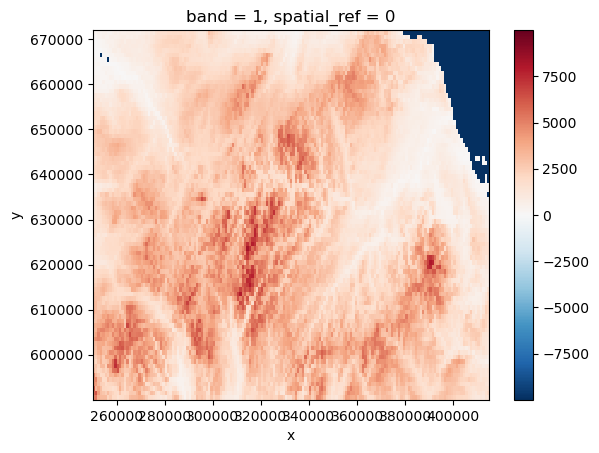

In [21]:
tweed_hght.plot()

In [22]:
def make_region_hght_clip(region_shp, hght_data):
    region_clip = hght_data.rio.clip(region_shp.geometry.values, region_shp.crs, drop=False, invert=False)
    return region_clip

In [23]:
def coerse_data_into_haduk_format(one_day_data, offset, xrange, yrange):
    """
    Quick fix for coersing data to have same grid as HADUK.
    """
    one_day_data = one_day_data.assign_coords(x=(one_day_data['x'] + offset))
    one_day_data = one_day_data.assign_coords(y=(one_day_data['y'] + offset))
    one_day_data = one_day_data.sel(x=xrange, y=yrange)
    one_day_data = one_day_data.rename({'x': 'projection_x_coordinate', 'y': 'projection_y_coordinate'})
    return one_day_data


In [24]:
def make_region_mask(region_data):
    """
    Make binary mask of clipped region data data
    """
    return (region_data/region_data.where(region_data>0))

In [25]:
tweed_xrange = slice(250500, 414550)
tweed_yrange = slice(590500, 671550)

In [26]:
norham_hght = make_region_hght_clip(norham_shp, hght_data=tweed_hght)
norham_clip_fmt = coerse_data_into_haduk_format(norham_hght, offset=25, xrange=tweed_xrange,\
                                                yrange=tweed_yrange)
norham_mask = make_region_mask(norham_clip_fmt)


In [27]:
norham_mask.shape, haduk_202001['rainfall'].shape

((82, 165), (31, 82, 165))

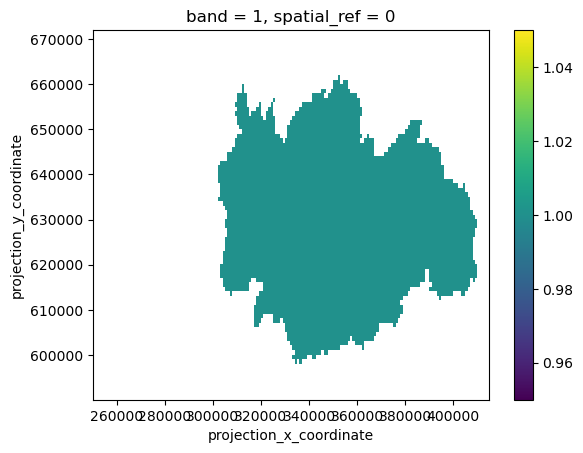

In [28]:
norham_mask.plot()

In [29]:
def mask_region_rainfall(rainfall_data, region_mask):
    return rainfall_data * region_mask.data


def mask_region_rainfall_by_hght(rainfall_data, region_hght, threshold):
    region_hght_mask = region_hght/region_hght.where(region_hght > threshold)
    region_hght_mask_fmt = coerse_data_into_haduk_format(region_hght_mask, offset=25, xrange=tweed_xrange, yrange=tweed_yrange)
    return rainfall_data * region_hght_mask_fmt.data

def sum_region_rainfall(rainfall_data):
    if 'time' in rainfall_data.dims:
        if rainfall_data.time.size > 1:
            return rainfall_data.sum('time')
    return rainfall_data.sum()

def calc_prop_rainfall_over_region(rainfall_data):
    if 'time' in rainfall_data.dims:
        if rainfall_data.time.size > 1:
            return rainfall_data.groupby('time').apply(lambda row: row/row.sum())
    return rainfall_data/rainfall_data.sum()

# Bringing it together

In [30]:
flood_data_dict.keys()

dict_keys(['flood200803', 'flood201811', 'flood202001', 'flood202102', 'flood202212'])

In [31]:
flood_to_examine = flood_data_dict["flood202212"]
flood_date = flood_to_examine["date"]
haduk_data = flood_to_examine["data"]
days_before_flood = 9 # 6 == 7 days before

In [32]:
def run_prop_rainfall_analysis(region_shp, flood_date, days_before_flood, haduk_data, hght_data):
    region_hght = make_region_hght_clip(region_shp, hght_data=hght_data)
    region_clip_fmt = coerse_data_into_haduk_format(region_hght, offset=25, xrange=tweed_xrange, yrange=tweed_yrange)
    region_mask = make_region_mask(region_clip_fmt)

    haduk_region_mask = mask_region_rainfall(haduk_data['rainfall'], region_mask)
    haduk_region_daysbefore_mask = haduk_region_mask.sel(time=slice((\
                                    flood_date-datetime.timedelta(days=days_before_flood)).strftime("%Y-%m-%d"),\
                                    flood_date.strftime("%Y-%m-%d")))
    haduk_region_mask_sum_prop = calc_prop_rainfall_over_region(sum_region_rainfall(haduk_region_daysbefore_mask))
    return haduk_region_mask_sum_prop

In [33]:
haduk_norham_mask_sum_prop = run_prop_rainfall_analysis(region_shp=norham_shp,\
                                                         flood_date=flood_date,\
                                                         days_before_flood=days_before_flood,
                                                         haduk_data=haduk_data,\
                                                         hght_data=tweed_hght)

In [34]:
haduk_kingledores_mask_sum_prop = run_prop_rainfall_analysis(region_shp=kingledores_shp,\
                                                         flood_date=flood_date,\
                                                         days_before_flood=days_before_flood,
                                                         haduk_data=haduk_data,\
                                                         hght_data=tweed_hght)

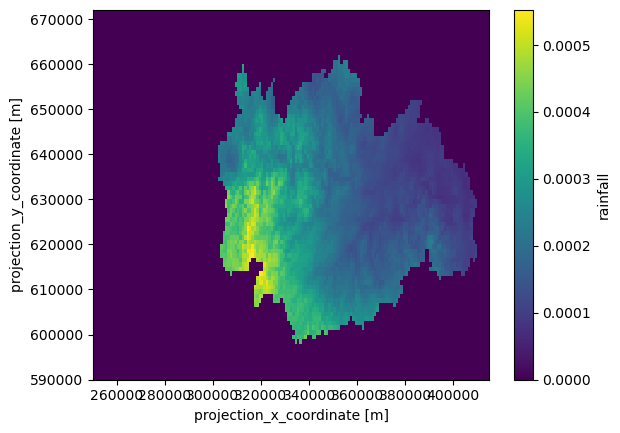

In [35]:
haduk_norham_mask_sum_prop.plot()

(295000.0, 324000.0)

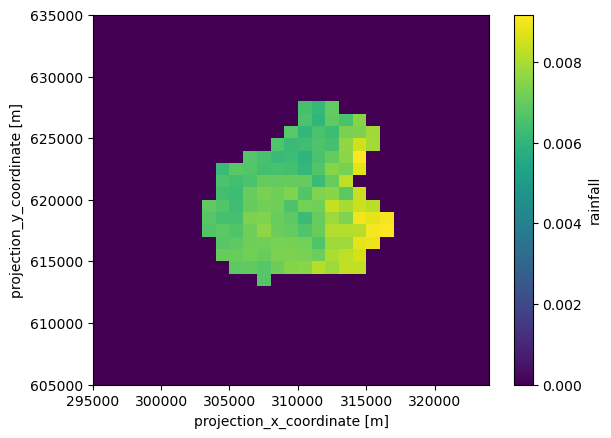

In [36]:
haduk_kingledores_mask_sum_prop.plot()
plt.ylim(605000, 635000)
plt.xlim(295000, 324000)

### Now mask by height

In [37]:
height_buffer = 0 # 500 == add 50 metres
kingledores_station_height = kingledores_station['HGHT'].values[0]
fruid_station_height = fruid_station['HGHT'].values[0]

kingledores_station_height_buffer = kingledores_station_height+height_buffer
fruid_station_height_buffer = fruid_station_height+height_buffer

In [38]:
norham_hght = make_region_hght_clip(norham_shp, hght_data=tweed_hght)
haduk_norham_mask_sum_prop_above_kingledores = mask_region_rainfall_by_hght(haduk_norham_mask_sum_prop, norham_hght, threshold=kingledores_station_height_buffer)
haduk_norham_mask_sum_prop_above_fruid = mask_region_rainfall_by_hght(haduk_norham_mask_sum_prop, norham_hght, threshold=fruid_station_height_buffer)

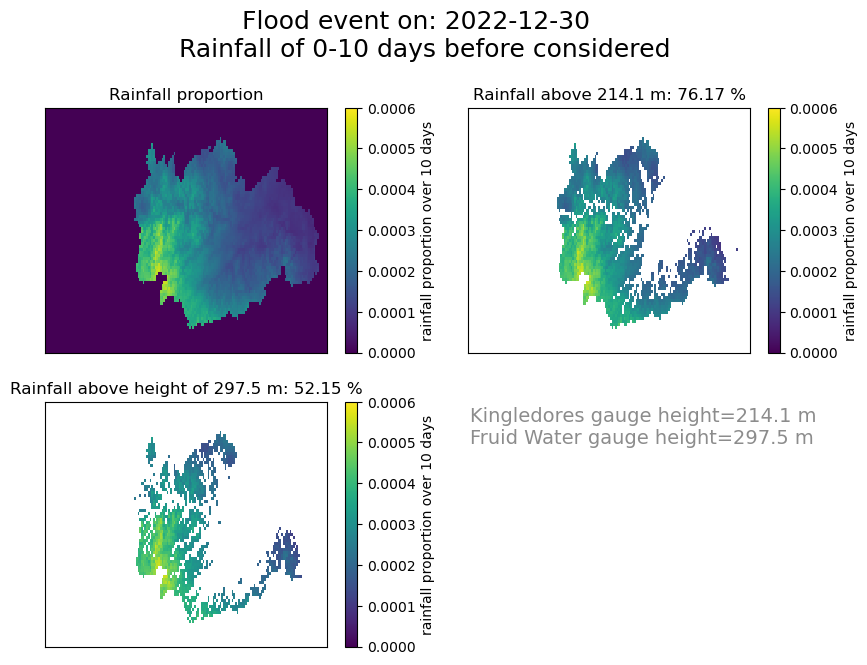

In [39]:
pnt_above_kingledores = (sum_region_rainfall(haduk_norham_mask_sum_prop_above_kingledores)*100).data.round(2)
pnt_above_fruid = (sum_region_rainfall(haduk_norham_mask_sum_prop_above_fruid)*100).data.round(2)
rain_prop_vmax = haduk_norham_mask_sum_prop.max().round(5)+0.00005

fig, axes = plt.subplots(2, 2, figsize=(10, 7))
haduk_norham_mask_sum_prop.plot(ax=axes[0][0], vmin=0, vmax=rain_prop_vmax,\
                                 cbar_kwargs={'label':f'rainfall proportion over {days_before_flood+1} days'})
axes[0][0].set_title('Rainfall proportion');
haduk_norham_mask_sum_prop_above_kingledores.plot(ax=axes[0][1], vmin=0, vmax=rain_prop_vmax,\
                                              cbar_kwargs={'label':f'rainfall proportion over {days_before_flood+1} days'})
axes[0][1].set_title(f'Rainfall above {kingledores_station_height_buffer/10} m: {pnt_above_kingledores} %');
haduk_norham_mask_sum_prop_above_fruid.plot(ax=axes[1][0], vmin=0, vmax=rain_prop_vmax,\
                                                 cbar_kwargs={'label':f'rainfall proportion over {days_before_flood+1} days'})
axes[1][0].set_title(f'Rainfall above height of {fruid_station_height_buffer/10} m: {pnt_above_fruid} %');

axes[1][1].remove()

for ax in axes.flatten():
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticks([]); ax.set_yticks([]);
plt.suptitle(f'Flood event on: {flood_date.strftime("%Y-%m-%d")} \n Rainfall of 0-{days_before_flood+1} days before considered',\
              y=1.02, size=18)
fig.text(s=f'Kingledores gauge height={kingledores_station_height/10} m\nFruid Water gauge height={fruid_station_height/10} m',\
          x=.55, y=.4, color='grey', alpha=.9, size=14)

fig.subplots_adjust(hspace=.2)
# plt.savefig(f'figures/tweed_{flood_date.strftime('%Y_%m_%d')}_{days_before_flood+1}d_prop_rain.png',\
            # bbox_inches='tight', dpi=200)

## Look at influence of height threshold

In [40]:
flood_to_examine = flood_data_dict["flood202001"]
days_before_flood = 9 # 9 == 10 days before

In [41]:
def calc_percentage_grid_cells_above_thresh(haduk_shp_mask_sum_prop, haduk_shp_mask_sum_prop_above_thresh):
    total_grid_cells = (haduk_shp_mask_sum_prop/haduk_shp_mask_sum_prop).sum()
    above_thresh_grid_cells = (haduk_shp_mask_sum_prop_above_thresh/haduk_shp_mask_sum_prop_above_thresh).sum()
    return ((above_thresh_grid_cells)/total_grid_cells)*100

Text(0.5, 1.0, 'River Tweed - 10d rain vs height')

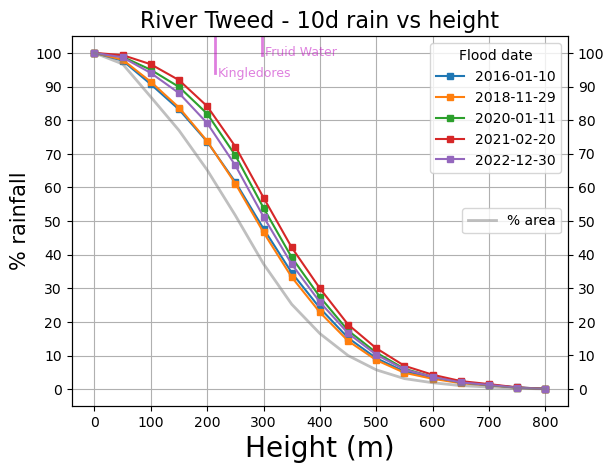

In [46]:
fig, ax = plt.subplots(1)
for flood_names in flood_data_dict.keys():
    flood_to_examine = flood_data_dict[flood_names]
    flood_date = flood_to_examine["date"]
    haduk_data = flood_to_examine["data"]
    haduk_norham_mask_sum_prop = run_prop_rainfall_analysis(region_shp=norham_shp,\
                                                            flood_date=flood_date,\
                                                            days_before_flood=days_before_flood,\
                                                            haduk_data=haduk_data,\
                                                            hght_data=tweed_hght)
    all_pnt_above_thresh = []
    all_num_cells = []
    height_thresholds = np.arange(0, norham_hght.max()+100, 500)
    for height_thresh in height_thresholds:
        haduk_norham_mask_sum_prop_above_thresh = mask_region_rainfall_by_hght(haduk_norham_mask_sum_prop, norham_hght, threshold=height_thresh)
        pnt_above_thresh = (sum_region_rainfall(haduk_norham_mask_sum_prop_above_thresh)*100).data.round(2)
        all_pnt_above_thresh.append(pnt_above_thresh)

        all_num_cells.append(calc_percentage_grid_cells_above_thresh(haduk_norham_mask_sum_prop, haduk_norham_mask_sum_prop_above_thresh))
    # Plot
    ax.plot(height_thresholds/10, all_pnt_above_thresh, marker='s', markersize=4, label=f'{flood_date.strftime("%Y-%m-%d")}')
    ax.grid()
    ax.legend(title="Flood date")
    ax.set_xlabel("Height (m)", size=20)
    ax.set_ylabel("% rainfall", size=15)
    ax.set_yticks(np.arange(0, 101, 10))
ax.axvline(x=kingledores_station_height/10, ymin=.9, ymax=1, c='m', alpha=.5, linewidth=2)
ax.axvline(x=fruid_station_height/10, ymin=.95, ymax=1, c='m', alpha=.5, linewidth=2)

ax.text(s="Kingledores", x=kingledores_station_height/10+5, y=93, alpha=.5, size=9, c='m')
ax.text(s="Fruid Water", x=fruid_station_height/10+5, y=99, alpha=.5, size=9, c='m')

ax2 = ax.twinx()
ax2.plot(height_thresholds/10, all_num_cells, color='grey', linewidth=2, alpha=.5)
ax2.legend(["% area"], loc=5)
ax2.set_yticks(np.arange(0, 101, 10));
ax.set_title("River Tweed - 10d rain vs height", size=16)
# fig.savefig('figures/tweed_all_floods_lineplot_threshold.png', bbox_inches='tight', dpi=300)

## Look at lead-up rainfall profile

In [43]:
num_lead_up_days = 15

Text(0.5, 1.0, 'River Tweed - lead up days vs rain')

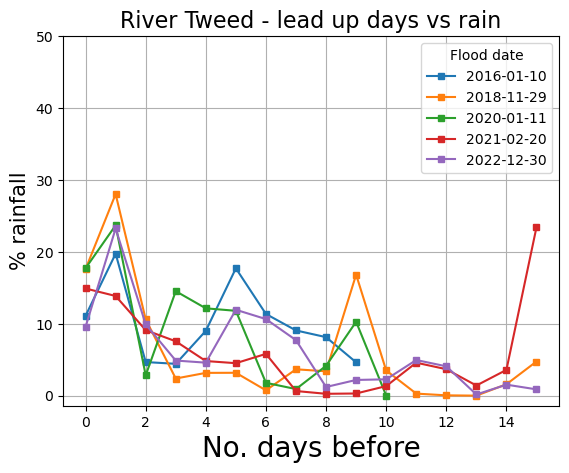

In [44]:
fig, ax = plt.subplots(1)
for flood_names in flood_data_dict.keys():
    flood_to_examine = flood_data_dict[flood_names]
    flood_date = flood_to_examine["date"]
    haduk_data = flood_to_examine["data"]

    haduk_daysbefore = haduk_data.sel(time=slice((\
                                flood_date-datetime.timedelta(days=num_lead_up_days)).strftime("%Y-%m-%d"),\
                                flood_date.strftime("%Y-%m-%d")))
    daily_total_rain = haduk_daysbefore['rainfall'].sum(('projection_x_coordinate', 'projection_y_coordinate'))
    pnt_total_rain = (daily_total_rain/daily_total_rain.sum())*100

    # Plot
    ax.plot(list(reversed(range(0, pnt_total_rain.data.shape[0]))), pnt_total_rain.data, marker='s', markersize=4, label=f'{flood_date.strftime("%Y-%m-%d")}')
    ax.grid()
    ax.legend(title="Flood date")
    ax.set_xlabel("No. days before", size=20)
    ax.set_ylabel("% rainfall", size=15)
    ax.set_yticks(np.arange(0, 51, 10))

ax.set_title("River Tweed - lead up days vs rain", size=16)
# fig.savefig('figures/tweed_all_floods_leadupdays.png', bbox_inches='tight', dpi=300)

Text(0.5, 1.0, 'River Tweed - lead up days vs rain')

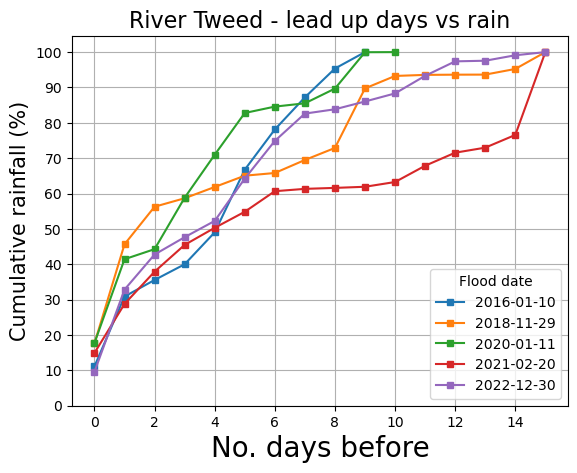

In [45]:
fig, ax = plt.subplots(1)
for flood_names in flood_data_dict.keys():
    flood_to_examine = flood_data_dict[flood_names]
    flood_date = flood_to_examine["date"]
    haduk_data = flood_to_examine["data"]

    haduk_daysbefore = haduk_data.sel(time=slice((\
                                flood_date-datetime.timedelta(days=num_lead_up_days)).strftime("%Y-%m-%d"),\
                                flood_date.strftime("%Y-%m-%d")))
    daily_total_rain = haduk_daysbefore['rainfall'].sum(('projection_x_coordinate', 'projection_y_coordinate'))
    pnt_total_rain = (daily_total_rain/daily_total_rain.sum())*100

    # Plot
    ax.plot(range(0, pnt_total_rain.data.shape[0]), np.cumsum(list(reversed(pnt_total_rain.data))), marker='s', markersize=4, label=f'{flood_date.strftime("%Y-%m-%d")}')
    ax.grid()
    ax.legend(title="Flood date")
    ax.set_xlabel("No. days before", size=20)
    ax.set_ylabel("Cumulative rainfall (%)", size=15)
    ax.set_yticks(np.arange(0, 101, 10))

ax.set_title("River Tweed - lead up days vs rain", size=16)
# fig.savefig('figures/tweed_all_floods_leadupdays_cumulative.png', bbox_inches='tight', dpi=300)